What's the error of the concentration field for all the learned R curves of all methods?

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import common

In [2]:
data_in_dir = Path("../data/")
data_out_dir = Path("../data_out/")

In [3]:
finn_dirs = [
    p.parent
    for p in data_out_dir.rglob("c_predictions.npy")
    if "quantile" not in str(p)
]
print(len(finn_dirs))
print(np.load(finn_dirs[0] / "c_predictions.npy").shape)

92
(51, 2, 26, 1)


In [4]:
c_true = np.load(data_in_dir / "synthetic_data/retardation_freundlich/c_train.npy")[
    ..., None
]
print(c_true.shape)

(2001, 2, 26, 1)


In [5]:
import re

data = ["test3", "testnew11", "testnew3", "test12", "testnew4", "test1"]


def natural_sort_key(s):
    """Key function for natural sorting."""
    return [
        int(text) if text.isdigit() else text.lower() for text in re.split("(\d+)", s)
    ]


sorted_data = sorted(data, key=natural_sort_key)

print(sorted_data)

['test1', 'test3', 'test12', 'testnew3', 'testnew4', 'testnew11']


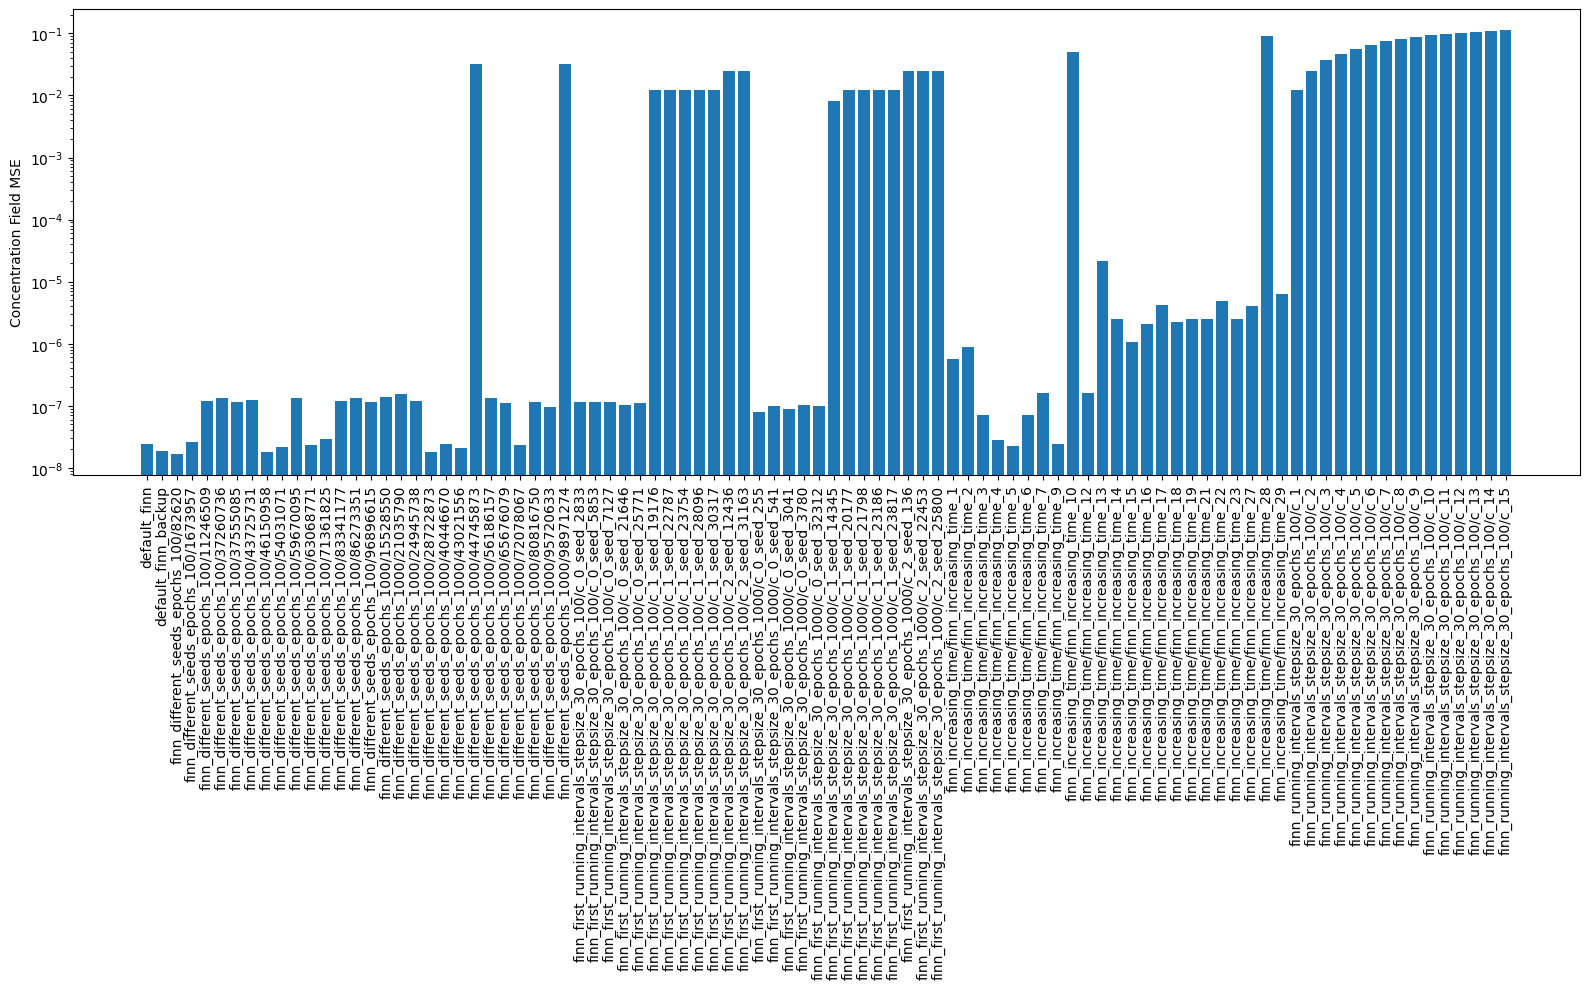

In [6]:
import matplotlib.pyplot as plt


def compute_c_error(c_pred, error_type: str):
    try:
        c_pred = np.load(c_pred)
    except TypeError:
        # assume we already have a np array
        pass

    if error_type == "L2":
        return np.mean(np.square(c_pred - c_true[: c_pred.shape[0]]))
    if error_type == "L1":
        return np.mean(np.abs(c_pred - c_true[: c_pred.shape[0]]))
    if error_type == "Linf":
        return np.max(np.abs(c_pred - c_true[: c_pred.shape[0]]))


def c_MSE(c_pred):
    return compute_c_error(c_pred, "L2")


def c_MAE(c_pred):
    return compute_c_error(c_pred, "L1")


def c_inf_error(c_pred):
    return compute_c_error(c_pred, "Linf")


def label_from_finn_dir(finn_dir):
    return str(finn_dir.relative_to(data_out_dir)).replace("/c_predictions.npy", "")


df = {
    "finn_dir": finn_dirs,
    "label": [label_from_finn_dir(p) for p in finn_dirs],
    "c_L2": np.array([c_MSE(p / "c_predictions.npy") for p in finn_dirs]),
    "c_L1": np.array([c_MAE(p / "c_predictions.npy") for p in finn_dirs]),
    "c_Linf": np.array([c_inf_error(p / "c_predictions.npy") for p in finn_dirs]),
}
categories = np.array(df["label"])
values = df["c_L2"]

# sort_indices = np.argsort(values, axis=0)
# sort_indices = np.argsort(categories, axis=0)
sort_indices = np.array(
    [i for i, x in sorted(enumerate(categories), key=lambda x: natural_sort_key(x[1]))]
)
sorted_categories = categories[sort_indices]
sorted_values = values[sort_indices]


plt.figure(figsize=(16, 10))
plt.bar(sorted_categories, sorted_values)
plt.xticks(rotation=90)
plt.ylabel("Concentration Field MSE")

plt.yscale("log")
plt.tight_layout()
plt.show()

In [38]:
df = pd.DataFrame(df)
display(df.head())
display(len(df))

,finn_dir,label,c_L2,c_L1,c_Linf
0,../data_out/finn_different_seeds_epochs_100/59...,finn_different_seeds_epochs_100/59670095,1.313741e-07,0.000219,0.002099
1,../data_out/finn_different_seeds_epochs_100/46...,finn_different_seeds_epochs_100/46150958,1.785935e-08,0.000049,0.002103
2,../data_out/finn_different_seeds_epochs_100/54...,finn_different_seeds_epochs_100/54031071,2.135460e-08,0.000065,0.002102
3,../data_out/finn_different_seeds_epochs_100/86...,finn_different_seeds_epochs_100/86273351,1.326400e-07,0.000220,0.002084
4,../data_out/finn_different_seeds_epochs_100/63...,finn_different_seeds_epochs_100/63068771,2.333679e-08,0.000072,0.002103


92

### Correlation between different error norms for concentration c

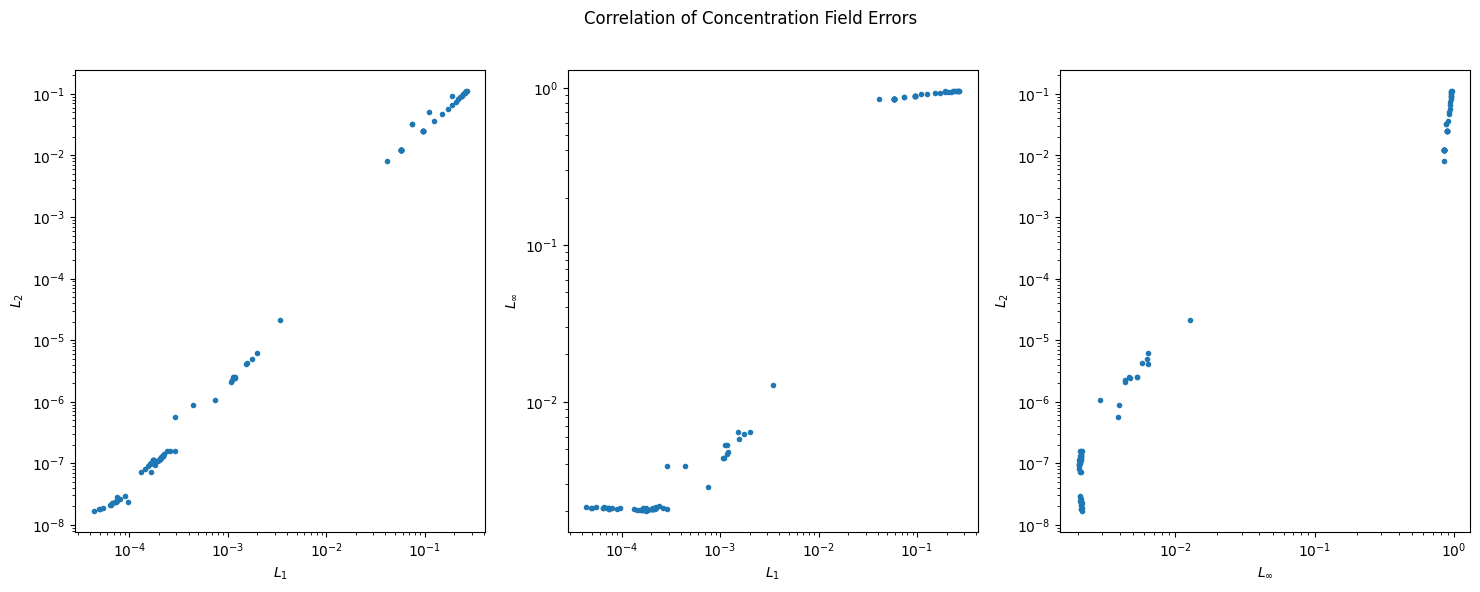

In [46]:
fig, axs = plt.subplots(ncols=3, figsize=(18, 6))

fig.suptitle("Correlation of Concentration Field Errors")
axs[0].loglog(df["c_L1"], df["c_L2"], ".")
axs[0].set_xlabel("$L_1$")
axs[0].set_ylabel("$L_2$")
axs[1].loglog(df["c_L1"], df["c_Linf"], ".")
axs[1].set_xlabel("$L_1$")
axs[1].set_ylabel("$L_{\infty}$")
axs[2].loglog(df["c_Linf"], df["c_L2"], ".")
axs[2].set_xlabel("$L_{\infty}$")
axs[2].set_ylabel("$L_2$")
plt.show()

# Correlation between c error and R error

## Load retardations

In [51]:
ret_freundlich = np.load("../data_out/default_finn/retardation_freundlich.npy")

ret_df = {
    "ret_L1": [],
    "ret_L2": [],
    "ret_Linf": [],
    
    "c_L1": [],
    "c_L2": [],
    "c_Linf": [],

    "label": [],
    "finn_dir": [],
    "ret_file_path": [],
}

for finn_dir in df["finn_dir"]:
    for finn_dir, ret_file_path in common.iter_final_retardation_files(finn_dir, verbose=False):
        ret = np.load(ret_file_path)

        mse = np.mean(np.square(ret - ret_freundlich))
        mae = np.mean(np.abs(ret - ret_freundlich))
        max_abs_err = np.max(np.abs(ret - ret_freundlich))
        
        # print(f"{mse=:.2e}   {finn_dir}")

        ret_df["ret_L1"].append(mae)
        ret_df["ret_L2"].append(mse)
        ret_df["ret_Linf"].append(max_abs_err)

        ret_df["c_L1"].append(c_MAE(finn_dir / "c_predictions.npy"))
        ret_df["c_L2"].append(c_MSE(finn_dir / "c_predictions.npy"))
        ret_df["c_Linf"].append(c_inf_error(finn_dir / "c_predictions.npy"))

        ret_df["label"].append(label_from_finn_dir(finn_dir))
        ret_df["finn_dir"].append(finn_dir)
        ret_df["ret_file_path"].append(ret_file_path)
        

ret_df = pd.DataFrame(ret_df)
display(ret_df.head())
display(len(ret_df))

,ret_L1,ret_L2,ret_Linf,c_L1,c_L2,c_Linf,label,finn_dir,ret_file_path
0,0.150194,0.732394,8.521996,0.000219,1.313741e-07,0.002099,finn_different_seeds_epochs_100/59670095,../data_out/finn_different_seeds_epochs_100/59...,../data_out/finn_different_seeds_epochs_100/59...
1,0.088652,0.549142,7.406955,0.000049,1.785935e-08,0.002103,finn_different_seeds_epochs_100/46150958,../data_out/finn_different_seeds_epochs_100/46...,../data_out/finn_different_seeds_epochs_100/46...
2,0.099402,0.593784,7.698691,0.000065,2.135460e-08,0.002102,finn_different_seeds_epochs_100/54031071,../data_out/finn_different_seeds_epochs_100/54...,../data_out/finn_different_seeds_epochs_100/54...
3,0.149718,0.734436,8.534468,0.000220,1.326400e-07,0.002084,finn_different_seeds_epochs_100/86273351,../data_out/finn_different_seeds_epochs_100/86...,../data_out/finn_different_seeds_epochs_100/86...
4,0.104067,0.608390,7.791194,0.000072,2.333679e-08,0.002103,finn_different_seeds_epochs_100/63068771,../data_out/finn_different_seeds_epochs_100/63...,../data_out/finn_different_seeds_epochs_100/63...


79

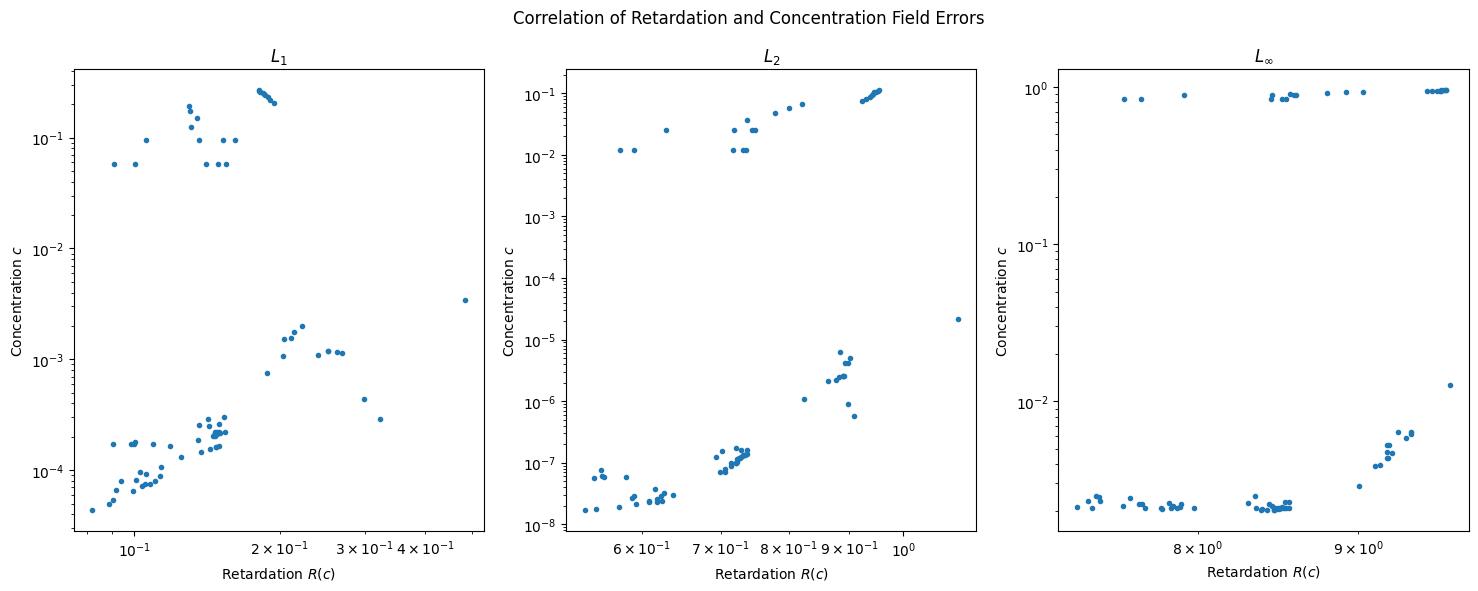

In [52]:
fig, axs = plt.subplots(ncols=3, figsize=(18, 6))
fig.suptitle("Correlation of Retardation and Concentration Field Errors")

axs[0].loglog(ret_df["ret_L1"], ret_df["c_L1"], ".")
axs[0].set_title("$L_1$")
axs[0].set_xlabel("Retardation $R(c)$")
axs[0].set_ylabel("Concentration $c$")

axs[1].loglog(ret_df["ret_L2"], ret_df["c_L2"], ".")
axs[1].set_title("$L_2$")
axs[1].set_xlabel("Retardation $R(c)$")
axs[1].set_ylabel("Concentration $c$")

axs[2].loglog(ret_df["ret_Linf"], ret_df["c_Linf"], ".")
axs[2].set_title("$L_{\infty}$")
axs[2].set_xlabel("Retardation $R(c)$")
axs[2].set_ylabel("Concentration $c$")

plt.show()

TODO:
- How does c look like (especially residual) for the high c-error results?
    - Is it qualitatively the same?
- Is some of this "weirdness" easiliy explained by the singularity at zero?
    - Because Linf gets a lot higher for R than the other ones. Especially L1 which is not so hard on high values has overall much lower errors for R

## Group dirs by error and show the R curves